In [1]:
import os
####*IMPORANT*: Have to do this line *before* importing tensorflow
os.environ['PYTHONHASHSEED']=str(2090341)

In [ ]:
####### IGNORE ALL WARNINGS THEYRE NOT IMPORTANT

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import math
import datetime as dt
import random
import copy

from math import sqrt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.layers import GaussianNoise
from keras.utils.vis_utils import plot_model


import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA,ARIMAResults

In [3]:
def reset_random_seed():
    sd = 2090341 # Here sd means seed.
    np.random.seed(sd)
    random.seed(sd)
    os.environ['PYTHONHASHSEED']=str(sd)
    tf.random.set_seed(sd)

In [4]:
BTC = pd.read_csv("/Users/denis/Desktop/Masters/Dissertation/CODE/data/BTCUSD_Daily.csv")
plt.rcParams["figure.figsize"] = (20,8)

In [5]:
close = BTC['Close']

In [6]:
BTC['pct_change'] = BTC['Close'].pct_change()

In [7]:
BTC['log_return'] = np.log(BTC['Close']) - np.log(BTC['Close'].shift(1))

In [8]:
#decomposing

decomposition = seasonal_decompose(BTC['Close'][1:1246], model = 'additive', period = 1)
observed = decomposition.observed
seasonal = decomposition.seasonal
trend = decomposition.trend
resid = decomposition.resid

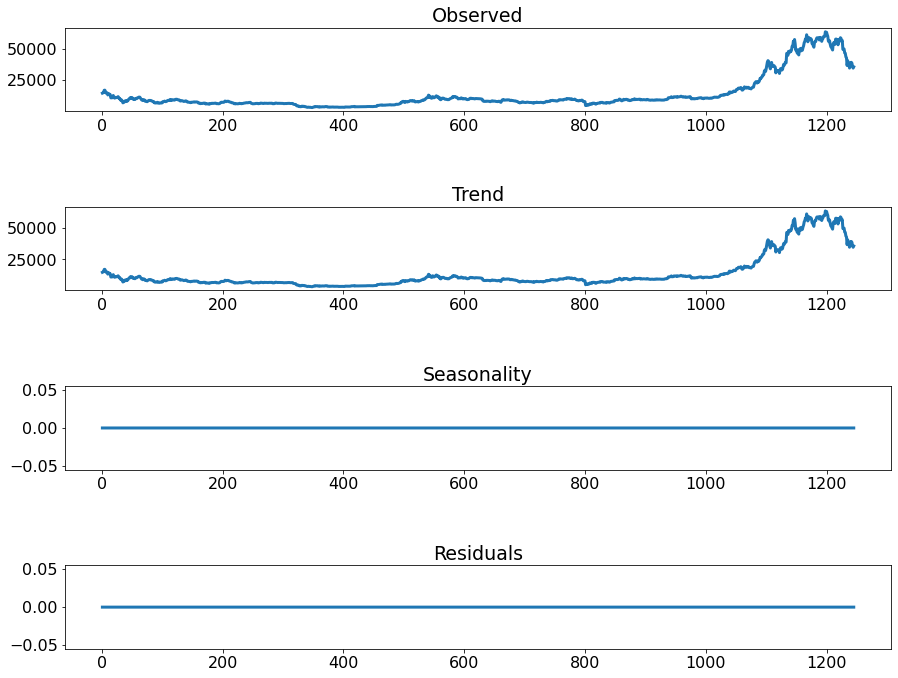

In [9]:
#decomposition plot

fig = plt.figure()

ax1 = fig.add_subplot(4,1,1)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.plot(observed,linewidth=3)
ax1.set_title('Observed',fontsize=19)
ax2 = fig.add_subplot(4,1,2)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.plot(trend,linewidth=3)
ax2.set_title('Trend',fontsize=19)
ax3 = fig.add_subplot(4,1,3)
ax3.tick_params(axis='both', which='major', labelsize=16)
ax3.plot(seasonal,linewidth=3)
ax3.set_title('Seasonality',fontsize=19)
ax4 = fig.add_subplot(4,1,4)
ax4.tick_params(axis='both', which='major', labelsize=16)
ax4.plot(resid,linewidth=3)
ax4.set_title('Residuals',fontsize=19)
fig.tight_layout(pad=3.0)
fig.set_size_inches(12.5, 10.5)
plt.savefig('/Users/denis/Desktop/Masters/Dissertation/Dissertation Latex/Paper/Figures/DecompositionBTC.pdf',transparent = False,bbox_inches='tight')

In [10]:
# decomposition of log return NOT USED IN report uncomment if interested...
#decomposition = seasonal_decompose(BTC['log_return'][1:1246], model = 'additive', period = 1).plot()

In [11]:

#train test split for ARIMA Model taking first 1200 days as training test data starts at the same day as our unseen data does in our neural network models 
close = BTC['Close']
close_train = close[0:1200]
close_test = close[1200:]
log_return = BTC['log_return']
log_return_train = log_return[0:1200]
log_return_test = log_return[1200:]
log_return_train.pop(0)

nan

In [12]:
#ADF TEST ON CLOSING PRICES

result = adfuller(close)

print(result[0])

#p-value
print(result[1])

-0.12054730743258966
0.947353093467169


In [13]:
#ACF and PACF plotting

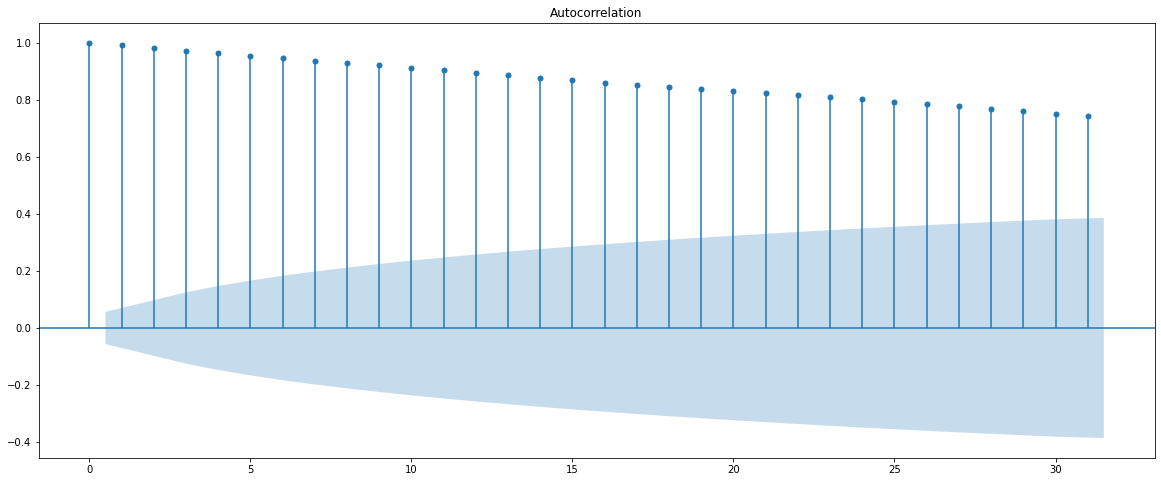

In [14]:
close_train_acf = plot_acf(close_train)

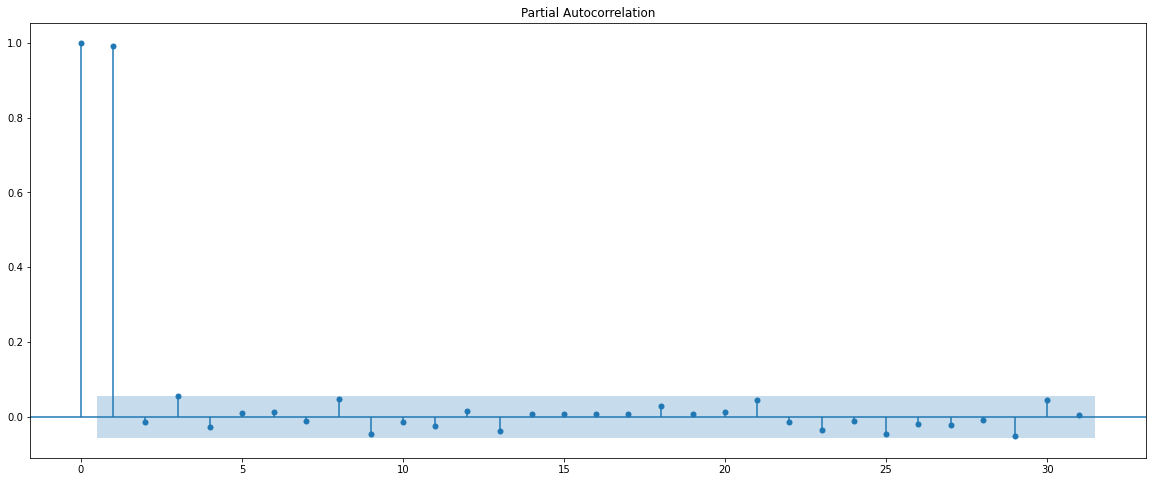

In [15]:
close_train_pacf = plot_pacf(close_train)

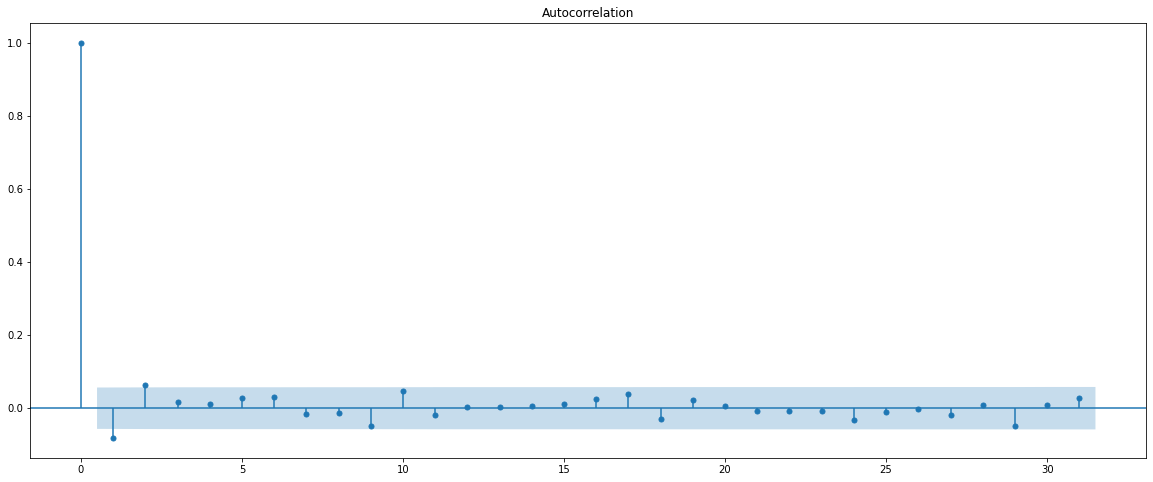

In [16]:
log_return_train_acf = plot_acf(log_return_train)

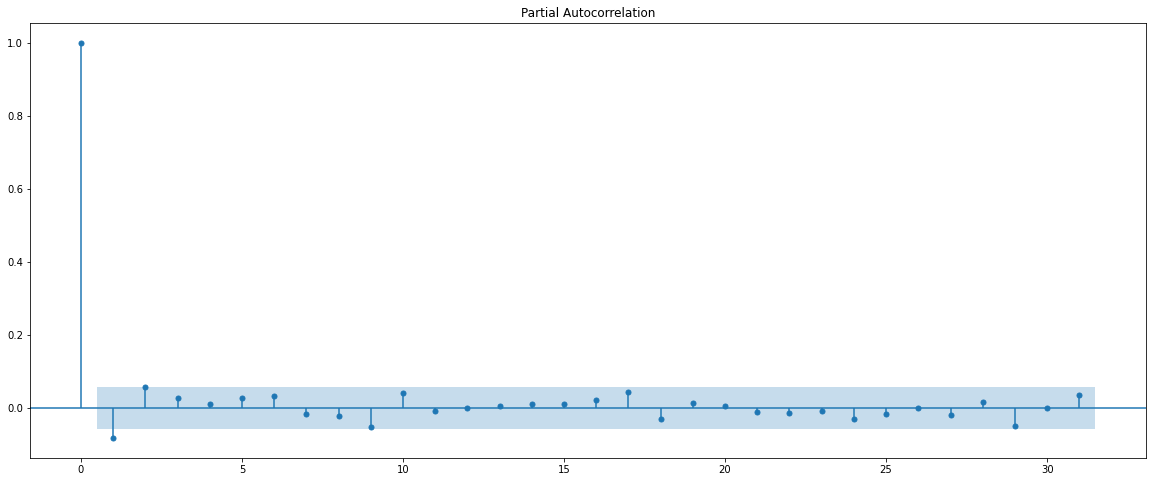

In [17]:
log_return_train_pacf =plot_pacf(log_return_train)

In [18]:
#difference close data once

In [19]:
diff = close_train.diff().dropna()

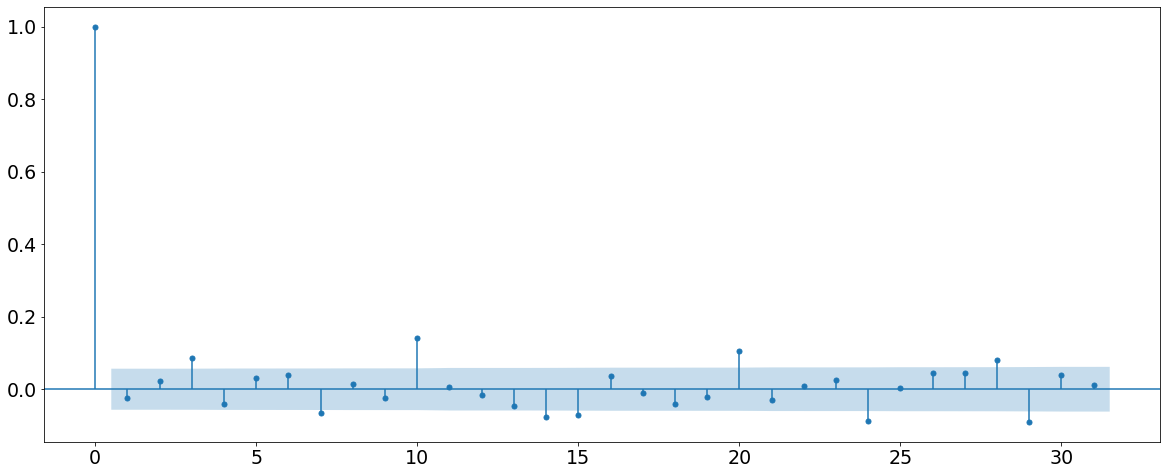

In [20]:
#acf of diff data
diff_acf = plot_acf(diff)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.title(label = '')
plt.savefig('/Users/denis/Desktop/Masters/Dissertation/Dissertation Latex/Paper/Figures/ACF.pdf',transparent = False,bbox_inches='tight')
plt.show()

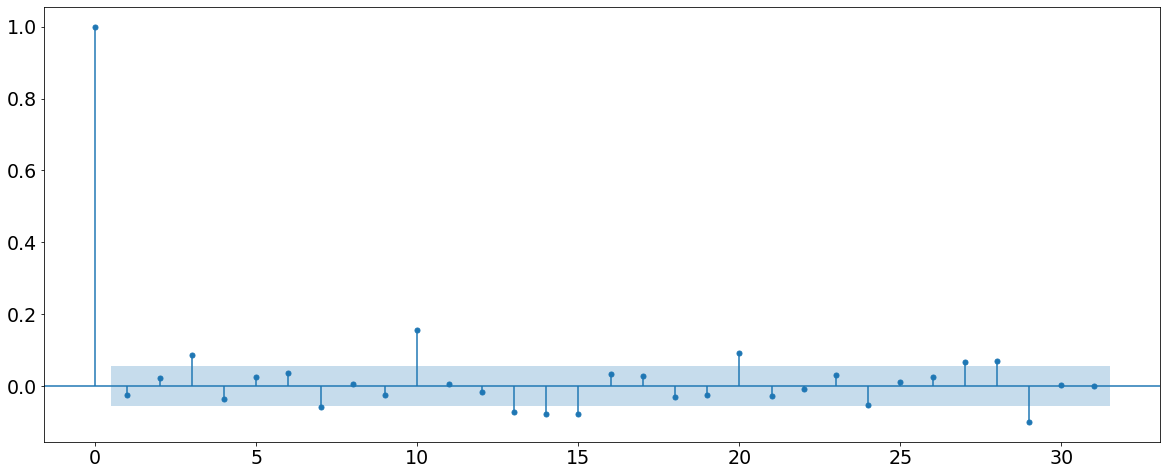

In [21]:
#pacf

diff_pacf = plot_pacf(diff)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.title(label = '')
plt.savefig('/Users/denis/Desktop/Masters/Dissertation/Dissertation Latex/Paper/Figures/PACF.pdf',transparent = False,bbox_inches='tight')
plt.show()

In [22]:
from pmdarima.arima.utils import ndiffs

In [23]:
ndiffs(close_train,test = 'adf') # this tells us how many times we need to difference the data to make it stationary (uses the adf test, same as before)

1

In [24]:
ndiffs(diff,test = 'adf')

0

In [25]:
ndiffs(log_return_train,test = 'adf')

0

In [26]:
#fitting the arima model, different models were experimented with for AR and MA parameters, ARIMA (2,1,2) was chosen as it is relatively simple with a lower AIC compared to other models with all parameters being statistically significant
model = ARIMA(close_train, order = (2,1,2))
result = model.fit()

In [27]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1200
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -9540.017
Date:                Wed, 08 Sep 2021   AIC                          19090.033
Time:                        14:13:37   BIC                          19115.480
Sample:                             0   HQIC                         19099.619
                               - 1200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5831      0.009    -62.348      0.000      -0.601      -0.565
ar.L2         -0.9745      0.009   -112.853      0.000      -0.991      -0.958
ma.L1          0.5488      0.009     58.678      0.0

In [28]:
forecast1 = result.forecast(steps = 40)

In [29]:
forecast1.values

array([63362.4214905 , 63358.07159248, 62967.98603377, 63199.69234542,
       63444.72196559, 63076.03963219, 63052.24224756, 63425.40390247,
       63230.99611235, 62980.70944683, 63316.10946737, 63364.4375324 ,
       63009.40548029, 63169.33609752, 63422.05965264, 63118.837004  ,
       63049.37084546, 63385.37178111, 63257.13791651, 63004.47732943,
       63276.77443472, 63364.2125805 , 63047.86906572, 63147.12637061,
       63397.5274462 , 63154.78587888, 63052.31518064, 63348.62231179,
       63275.69803722, 63029.46727531, 63244.11522248, 63358.90390021,
       63082.79142407, 63131.93575732, 63372.35320723, 63184.26893528,
       63059.6555414 , 63315.61043473, 63287.79471333, 63054.58387117])

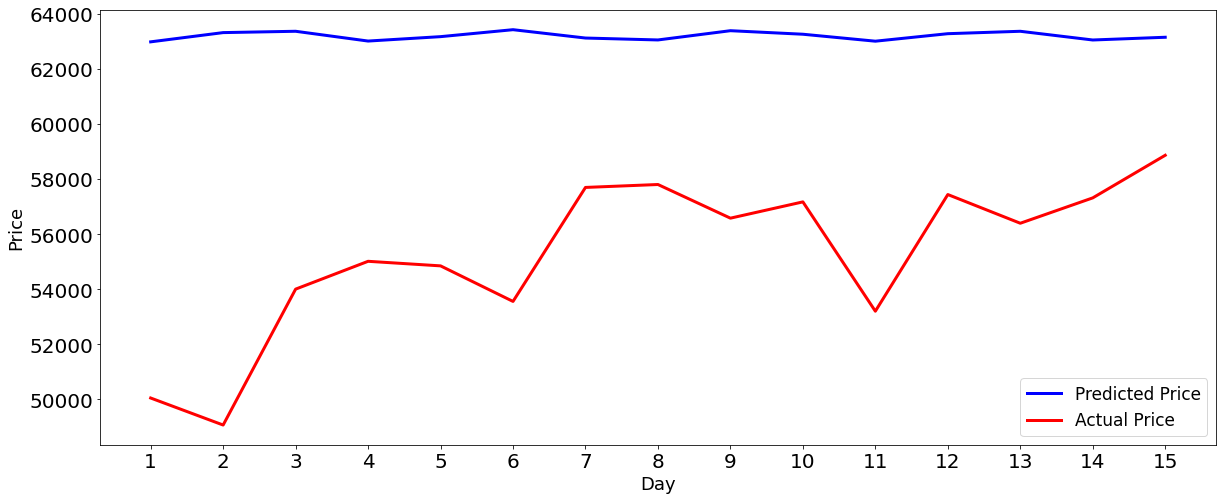

In [30]:
#plots the relevant days for our predictions

a = np.arange(1,16)
plt.plot(a,forecast1.iloc[9:24].values,label = 'Predicted Price', linewidth = 3,color = 'blue')
plt.plot(a,close_test.iloc[9:24].values,label = 'Actual Price', linewidth = 3, color = 'red')
plt.xlabel("Day",fontsize = 18)
plt.ylabel("Price",fontsize = 18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(np.arange(1, 16, step=1))
plt.legend(loc = 4, prop={'size': 17})
plt.savefig('/Users/denis/Desktop/Masters/Dissertation/Dissertation Latex/Paper/Figures/ARIMAProjections1.pdf',transparent = False,bbox_inches='tight')



In [31]:
#second way of refitting model every five days ignore the warnings

history = close_train
close_test = close_test[0:30]
preds = []
for i in range(0,len(close_test),5):
    model = ARIMA(history, order = (2,1,2))
    result = model.fit()
    fiveday = result.forecast(steps = 5)
    history = history.append(close_test[i:i+5])
    preds.append(fiveday)

/Users/denis/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [32]:
args = (preds[0],preds[1],preds[2],preds[3],preds[4],preds[5])
predictions = np.concatenate(args)

In [33]:
close_test = close_test.reset_index(drop = True)

In [34]:
#get the same 15 days predictions same as the RNN predictions
testsample = close_test[9:].reset_index(drop = True)

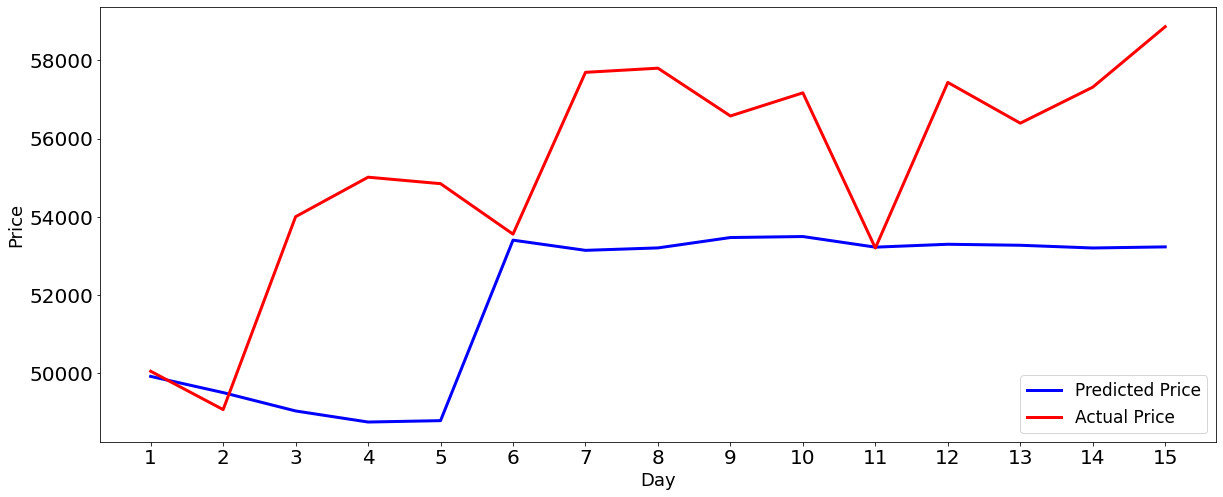

In [35]:

#plot
a = np.arange(1,16)
plt.plot(a,predictions[10:25],linewidth = 3, color = 'blue',label = 'Predicted Price')
plt.plot(a,testsample[:15],label = 'Actual Price', linewidth = 3, color = 'red')
plt.xlabel("Day",fontsize = 18)
plt.ylabel("Price",fontsize = 18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(np.arange(1, 16, step=1))
plt.legend(loc = 4, prop={'size': 17})
plt.savefig('/Users/denis/Desktop/Masters/Dissertation/Dissertation Latex/Paper/Figures/ARIMAProjections2.pdf',transparent = False,bbox_inches='tight')

In [36]:
#TESTING THE NOISE ROBUSTNESS

In [37]:
def TimeSeriesNoiseInjection(train,fraction,strength):
    random.seed(100)
    noisytrain = copy.deepcopy(train)
    n = noisytrain.shape[0]
    mean = noisytrain.mean()
    numnoise = int(fraction*n)
    
    indices = random.sample(range(1,n),numnoise)
    m = len(indices)
    noise = np.random.normal(mean*0.06,strength,numnoise)
    for i in range(0,m):
        j = indices[i]
        noisytrain[j] += noise[i]
        
    return noise,noisytrain
    
    

In [38]:
noise,noisy_close_train = TimeSeriesNoiseInjection(close_train,0.1,0.15)

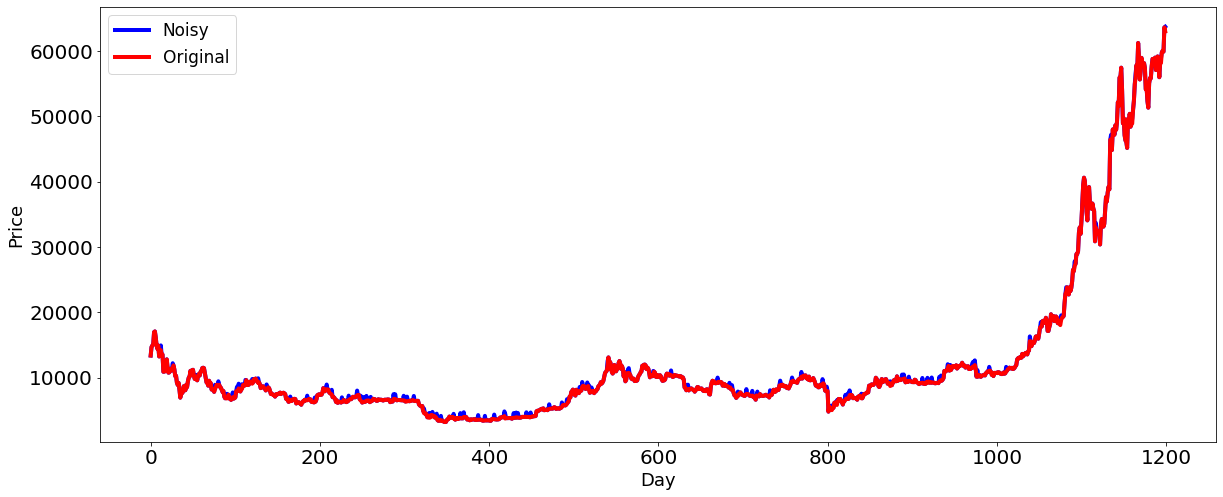

In [39]:
plt.plot(noisy_close_train[0:1200],label = 'Noisy',linewidth = 4,color ='blue')
plt.plot(close[0:1200],label = 'Original',linewidth = 4,color = 'red')
plt.legend(loc = 2,  prop={'size': 17})
plt.xlabel("Day",fontsize = 18)
plt.ylabel("Price",fontsize = 18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('/Users/denis/Desktop/Masters/Dissertation/Dissertation Latex/Paper/Figures/ARIMANoise.pdf',transparent = False,bbox_inches='tight')

In [40]:
model = ARIMA(noisy_close_train, order = (2,1,2))
result = model.fit()

In [41]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1200
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -9652.586
Date:                Wed, 08 Sep 2021   AIC                          19315.172
Time:                        14:13:44   BIC                          19340.618
Sample:                             0   HQIC                         19324.757
                               - 1200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0512      0.088    -12.002      0.000      -1.223      -0.880
ar.L2         -0.5490      0.100     -5.491      0.000      -0.745      -0.353
ma.L1          0.9768      0.092     10.588      0.0

In [42]:
#fit model again using 5 day reset, not shown in report as not important as the model is not good at making predictions before the noise injhections #ignore the warnings
history = noisy_close_train
close_test = close_test[0:30]
preds = []
for i in range(0,len(close_test),5):
    model = ARIMA(history, order = (2,1,2))
    result = model.fit()
    fiveday = result.forecast(steps = 5)
    history = history.append(close_test[i:i+5])
    preds.append(fiveday)

/Users/denis/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/denis/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/denis/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/denis/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index

In [43]:
noisyargs = (preds[0],preds[1],preds[2],preds[3],preds[4],preds[5])
noisypredictions = np.concatenate(noisyargs)

In [44]:
close_test = close_test.reset_index(drop = True)

In [45]:
testsample = close_test[9:].reset_index(drop = True)

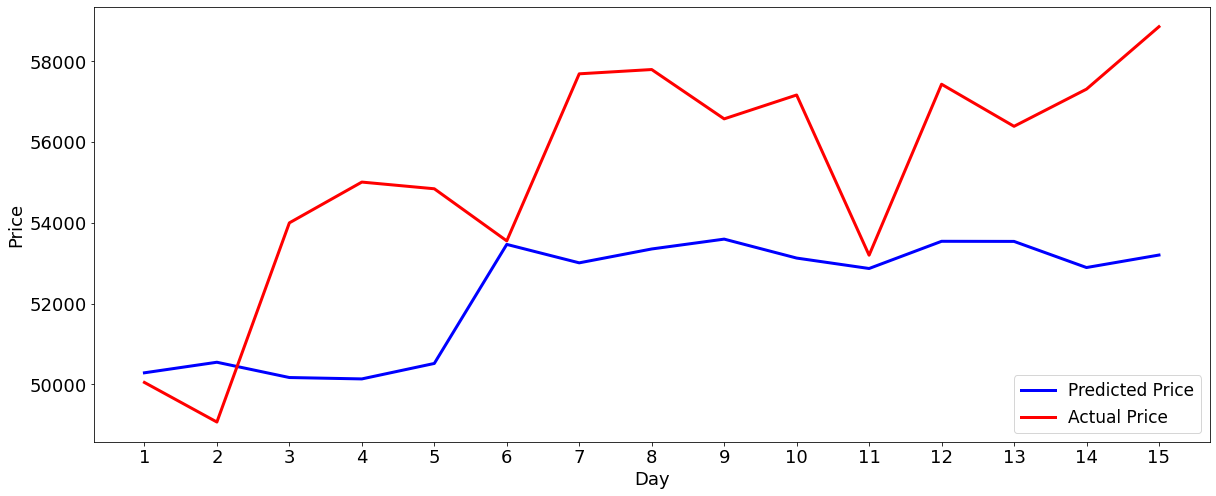

In [46]:
#plot of predictions on noisy trained model, not different from previous plots so not added to the report

a = np.arange(1,16)
plt.plot(a,noisypredictions[10:25],label = 'Predicted Price', linewidth = 3,color = 'blue')
plt.plot(a,testsample[:15],label = 'Actual Price', linewidth = 3, color = 'red')
plt.xlabel("Day",fontsize = 18)
plt.ylabel("Price",fontsize = 18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(np.arange(1, 16, step=1))
plt.legend(loc = 4, prop={'size':17 })
plt.savefig('/Users/denis/Desktop/Masters/Dissertation/Dissertation Latex/Paper/Figures/ARIMAProjections2Noisy.pdf',transparent = False,bbox_inches='tight')